In [1]:
import os
import sys

from pathlib import Path

# Get the current working directory
cwd = Path(os.getcwd())

# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)

# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels

# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

import warnings
import corr_fitter.bs_utils as bs
import corr_fitter.bs_analysis as bs_analysis
import corr_fitter.load_data_priors as ld
import corr_fitter.corr_fit_analysis as fa
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import h5py as h5
import importlib
import numpy as np
import gvar as gv
import pandas as pd
import platform
from tabulate import tabulate


warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/Users/grantdb/lqcd/corr_fitter


In [2]:
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd/corr_fitter'
else:
    base_dir = '/home/gmoney/lqcd/corr_fitter'
input_dir = os.path.join(base_dir, "tests/input_files")
data_dir = os.path.join(base_dir, "data")
fit_results_dir = os.path.join(base_dir, "fit_results")
if platform.system() == 'Darwin':
    data_file = '/Users/grantdb/lqcd/data/c51_2pt_octet_decuplet.h5'
else:
    data_file = '/home/gmoney/lqcd/data/c51_2pt_octet_decuplet.h5'
# hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
model_type = 'hyperons'
t_plot_min = 0
t_plot_max = 40
bs_N = 100
bs_seed = "seed"

Fit result for t_range [12, 25]: 
 Least Square Fit:
  chi2/dof [dof] = 1.2 [182]    Q = 0.047    logGBF = 5165.7

Parameters:
     proton_z_PS 0    3.56(14)e-08      [ 0.00000 (33) ]  
                 1    2.14(29)e-07      [ 0.00000 (33) ]  
     proton_z_SS 0   1.547(57)e-08      [ 4.4(4.4)e-06 ]  
                 1    7.50(93)e-08      [ 4.4(4.4)e-06 ]  
      delta_z_PS 0    9.73(49)e-08      [ 0.00000 (33) ]  
                 1   1.165(64)e-06      [ 0.00000 (33) ]  
      delta_z_SS 0    4.90(24)e-08      [ 4.4(4.4)e-06 ]  
                 1    4.31(19)e-07      [ 4.4(4.4)e-06 ]  
   sigma_st_z_PS 0    4.25(14)e-08      [ 0.00000 (33) ]  
                 1    4.58(18)e-07      [ 0.00000 (33) ]  
   sigma_st_z_SS 0   2.113(67)e-08      [ 0.00000 (33) ]  
                 1   1.668(52)e-07      [ 0.00000 (33) ]  
      sigma_z_PS 0    6.34(16)e-08      [ 0.00000 (33) ]  
                 1    3.88(26)e-07      [ 0.00000 (33) ]  
      sigma_z_SS 0   2.736(65)e-08      [ 0.000

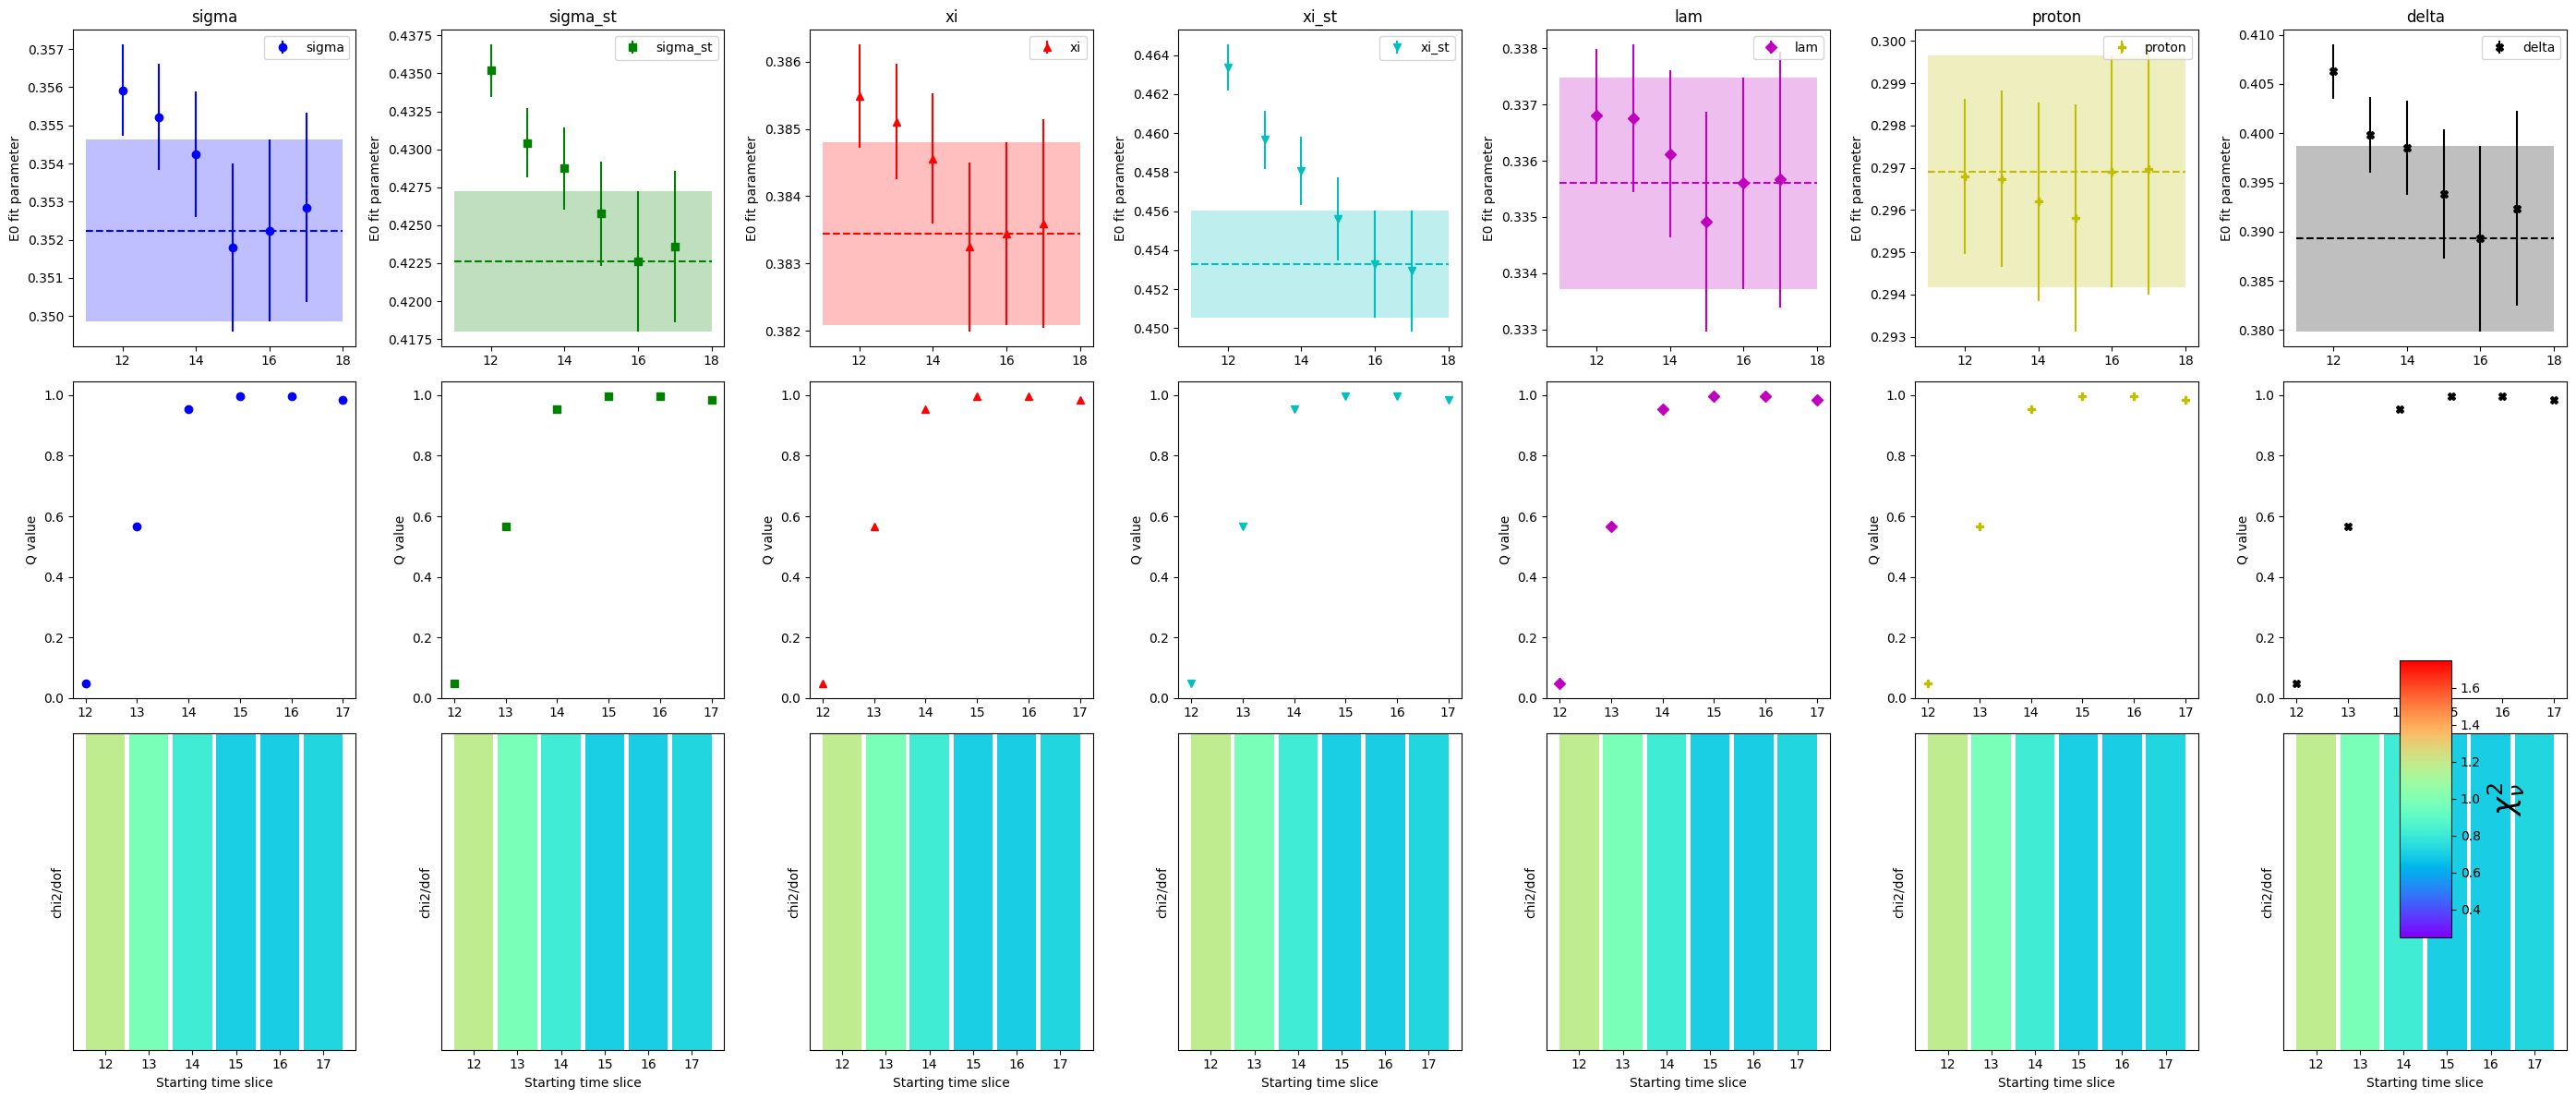

AttributeError: 'dict' object has no attribute 'p'

In [14]:
importlib.reload(fa)
abbr = 'a06m220L'
fit_params = os.path.join(input_dir, f"{abbr}.py")
sys.path.append(os.path.dirname(os.path.abspath(fit_params)))
fp = importlib.import_module(fit_params.split('/')[-1].split('.py')[0])
p_dict = fp.p_dict
hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params, model_type=model_type,
                                               bs=False, bs_file=bs_data_file,
                                               bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
print(hyperon_fit)
plot_fit_parameters(hyperon_fit, p_dict,abbr)
ld.generate_latex_line(hyperon_fit)


ValueError: 'x' and 'y' must have the same size

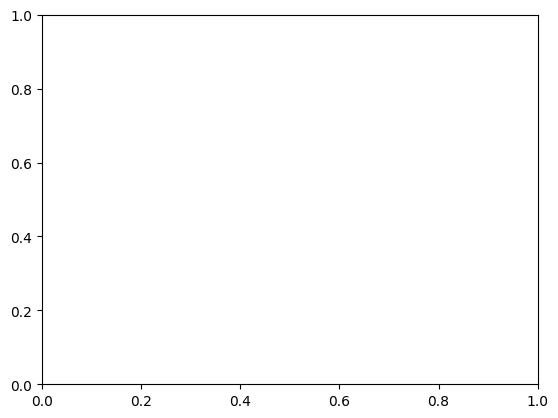

In [ ]:
import matplotlib.pyplot as plt

# Extract E0 fit parameters
def extract_e0_params(hyperon_base_fit, baryons, n_states):
    e0_params = {}
    for baryon in baryons:
        e0_params[baryon] = []
        for state in range(n_states):
            param_key = f"{baryon}_E0"
            e0_params[baryon].append(hyperon_base_fit.p[param_key])
    return e0_params

# Create stability plot
def plot_e0_stability(e0_params, t_range):
    for baryon, e0_values in e0_params.items():
        plt.errorbar(t_range, [gv.mean(e0) for e0 in e0_values], yerr=[gv.sdev(e0) for e0 in e0_values], fmt='o-', label=baryon)

    plt.xlabel('Time slice')
    plt.ylabel('E0 fit parameter')
    plt.legend()
    plt.grid()
    plt.title('Stability plot of E0 fit parameter')
    plt.show()

# Define your parameters
baryons = ['lam', 'sigma', 'sigma_st', 'xi_st', 'xi']
n_states = 2
t_range = p_dict['t_range']

# Extract E0 fit parameters
e0_params = extract_e0_params(my_fit, baryons, n_states)

# Create the stability plot
plot_e0_stability(e0_params, t_range)


Least Square Fit:
  chi2/dof [dof] = 0.87 [140]    Q = 0.86    logGBF = 3331.7

Parameters:
   sigma_st_z_PS 0   4.680(87)e-06      [ 0.0(3.3)e-05 ]  
                 1       4(12)e-07      [ 0.0(3.3)e-05 ]  
   sigma_st_z_SS 0   2.252(36)e-07      [ 0.0(3.3)e-05 ]  
                 1    3.6(4.5)e-07      [ 0.0(3.3)e-05 ]  
      sigma_z_PS 0   5.070(85)e-06      [ 0.0(3.3)e-05 ]  
                 1       2(94)e-08      [ 0.0(3.3)e-05 ]  
      sigma_z_SS 0   1.915(31)e-07      [ 0.0(3.3)e-05 ]  
                 1    2.6(2.0)e-07      [ 0.0(3.3)e-05 ]  
        lam_z_PS 0    5.86(11)e-06      [ 0.0(3.3)e-05 ]  
                 1   0.000024 (25)      [ 0.0(3.3)e-05 ]  
        lam_z_SS 0   2.117(35)e-07      [ 4.4(4.4)e-06 ]  
                 1    3.0(3.3)e-06      [ 4.4(4.4)e-06 ]  
     proton_z_PS 0    5.4(1.1)e-06      [ 0.0(3.3)e-05 ]  
                 1    3.4(3.2)e-06      [ 0.0(3.3)e-05 ]  
     proton_z_SS 0    1.98(40)e-07      [ 0.0(3.3)e-05 ]  
                 1    1

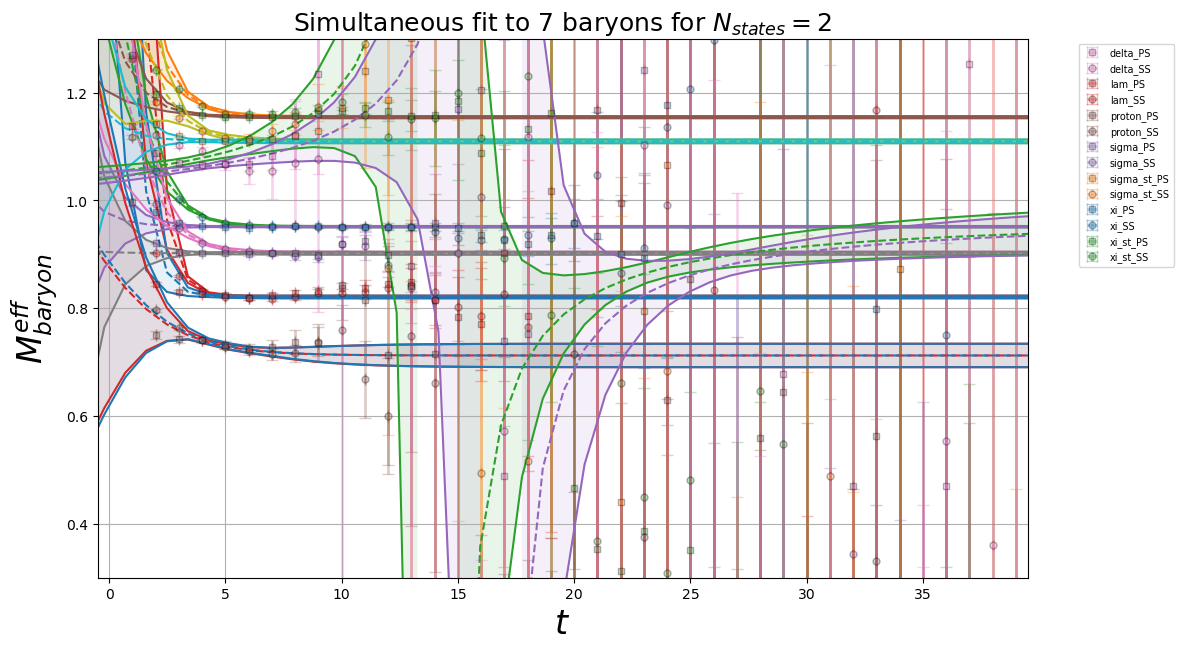

Abbreviation: a15m130
╒════╤═══════════════╤═══════════════╤════════════╤════════════╤══════════╤══════════╤═════════════╤═════════════╤════════════╤════════════╤════════════╤════════════╤═════════╤═════════╤══════════╤═══════════════╤════════╤═════════════╤═══════╤════════════╤══════════╤═══════════════╤═════════════╤══════════════════╤═══════════╤════════════════╤══════════╤═══════════════╕
│    │ 0             │ 1             │ 2          │ 3          │ 4        │ 5        │ 6           │ 7           │ 8          │ 9          │ 10         │ 11         │ 12      │ 13      │ 14       │ 15            │ 16     │ 17          │ 18    │ 19         │ 20       │ 21            │ 22          │ 23               │ 24        │ 25             │ 26       │ 27            │
╞════╪═══════════════╪═══════════════╪════════════╪════════════╪══════════╪══════════╪═════════════╪═════════════╪════════════╪════════════╪════════════╪════════════╪═════════╪═════════╪══════════╪═══════════════╪════════╪════════

In [ ]:
# from tabulate import tabulate

# abbreviations = [f[:-3] for f in os.listdir(input_dir) if f.endswith('.py')]

# for abbr in abbreviations:
#     fit_params = os.path.join(input_dir, f"{abbr}.py")
#     if not os.path.exists(fit_params):
#         print(f"Error: input file {fit_params} does not exist!")
#         continue

#     with open(fit_params, 'r') as f:
#         input_file_contents = f.read()

#     if 'p_dict' not in input_file_contents:
#         print(f"Error: input file {fit_params} does not contain a dictionary called 'p_dict'!")
#         continue

#     try:
#         p_dict = {}
#         exec(input_file_contents, p_dict)
#     except Exception as e:
#         print(f"Error: Failed to execute the contents of input file {fit_params}!\n{str(e)}")
#         continue

#     if 'tag' not in p_dict:
#         print(f"Warning: input file {fit_params} does not contain a dictionary called 'tag' within the 'p_dict' dictionary! Adding default values...")
#         p_dict['tag'] = {
#             'sigma' : 'sigma',
#             'sigma_st' : 'sigma_st',
#             'xi' :  'xi',
#             'xi_st' : 'xi_st',
#             'lam' : 'lam',
#         }

#     try:
#         hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params, model_type=model_type,
#                                                bs=False, bs_file=bs_data_file,
#                                                bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
#     except KeyError:
#         print(f"KeyError: Error analyzing hyperons for input file {fit_params}. Skipping abbreviation {abbr}.")
#         continue

#     my_fit = hyperon_fit.get_fit()

#     out_path = os.path.join(fit_results_dir, abbr, model_type)
#     ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
#     plot1 = hyperon_fit.return_best_fit_info()
#     plot2 = hyperon_fit.plot_effective_mass(t_plot_min=t_plot_min, t_plot_max=t_plot_max, model_type=model_type,
#                                             show_plot=True, show_fit=True)

#     output_dir = os.path.join(fit_results_dir, abbr, f"{model_type}_{abbr}")
#     os.makedirs(output_dir, exist_ok=True)
#     output_pdf = os.path.join(output_dir, 'output.pdf')
#     with PdfPages(output_pdf) as pp:
#         pp.savefig(plot1)
#         pp.savefig(plot2)

#     params_df = pd.DataFrame(my_fit.p).transpose()

#     print("Abbreviation:", abbr)
#     print(tabulate(params_df, headers='keys', tablefmt='fancy_grid'))

#     # Ask the user if the fit result is acceptable
#     while True:
#         result = input(f"Is the fit result for abbreviation {abbr} acceptable? (y/n): ")
#         if result == "y":
#             # Save the result and skip this fit in future runs
#             out_path = 'fit_results/{0}/{1}/'.format(abbr, model_type)
#             ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
#             break
#         elif result == "n":
#             break
